<a href="https://colab.research.google.com/github/24f1002320/Deep-Learning/blob/main/HotDog_NotHotdog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

In [2]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.I20LX7_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.I20LX7_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [21]:
train_ds,valid_ds = ds["train"],ds["validation"]

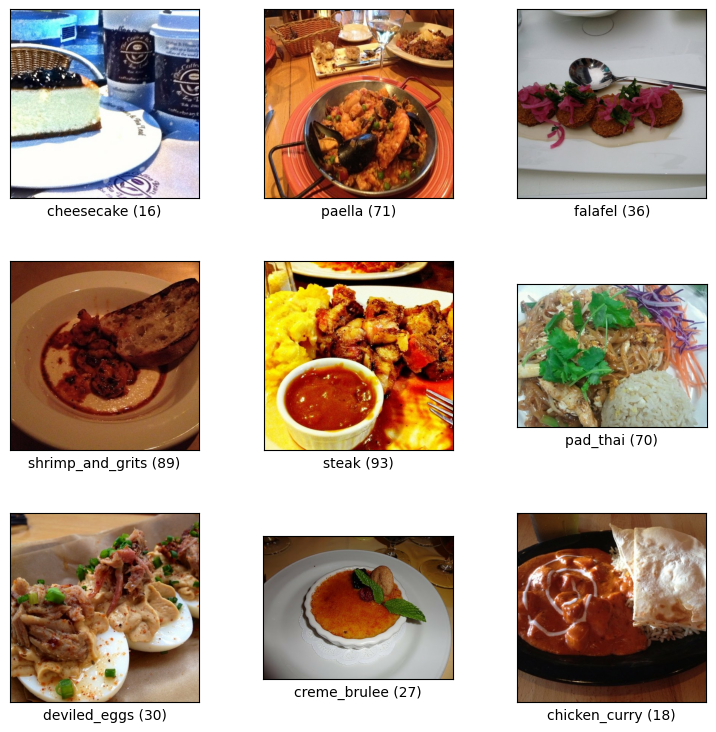

In [9]:
fig = tfds.show_examples(train_ds,ds_info)

In [22]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label :(tf.cast(tf.image.resize(image,[MAX_SIDE_LEN,MAX_SIDE_LEN]), dtype=tf.int32),
                           tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
valid_ds = valid_ds.map(
    lambda image, label :(tf.cast(tf.image.resize(image,[MAX_SIDE_LEN,MAX_SIDE_LEN]), dtype=tf.int32),
                           tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

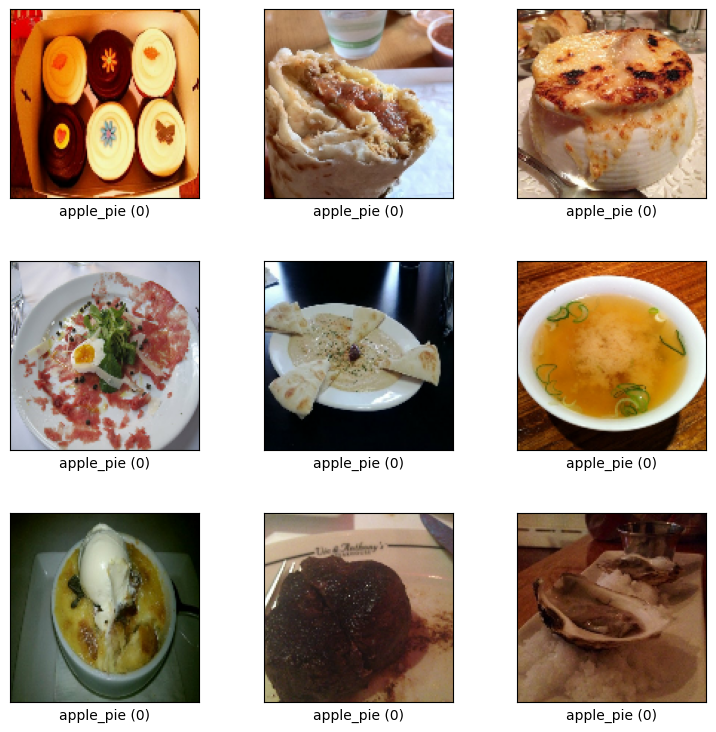

In [23]:
fig = tfds.show_examples(train_ds,ds_info)

In [24]:
train_hd_size,valid_hd_size = 750,250

train_hotdog = train_ds.filter(lambda image , label : label ==1 ).repeat(3)
train_nothotdog = train_ds.filter(lambda image , label : label ==0 )


In [25]:
valid_hotdog = valid_ds.filter(lambda image , label : label ==1 ).repeat(3)
valid_nothotdog = valid_ds.filter(lambda image , label : label ==0 )

In [26]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdog,train_nothotdog],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdog,valid_nothotdog],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [27]:
for image_batch,label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[164 176 155]
   [192 207 195]
   [202 221 211]
   ...
   [252 255 248]
   [253 255 249]
   [253 255 249]]

  [[123 105  98]
   [124 130 122]
   [146 167 156]
   ...
   [252 255 248]
   [253 255 249]
   [253 255 249]]

  [[156 165 155]
   [177 195 183]
   [120 138 127]
   ...
   [254 255 249]
   [254 255 249]
   [254 255 249]]

  ...

  [[138 123  97]
   [137 121 100]
   [136 119 101]
   ...
   [148 132 115]
   [146 130 113]
   [144 127 107]]

  [[139 126  99]
   [139 126 101]
   [144 130 107]
   ...
   [149 131 112]
   [150 132 113]
   [152 133 110]]

  [[139 129 102]
   [135 127  98]
   [138 132 103]
   ...
   [149 127 104]
   [151 127 105]
   [151 127 101]]]


 [[[232 228 222]
   [235 231 224]
   [229 225 219]
   ...
   [235 235 227]
   [230 230 223]
   [226 227 221]]

  [[243 243 238]
   [242 242 237]
   [242 242 237]
   ...
   [241 238 230]
   [242 240 232]
   [246 245 239]]

  [[244 244 239]
   [234 234 229]
   [247 247 242]
   ...
   [250 248 244]
   [241 240 237]


## Neural Network Implement

In [34]:
data_agumentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [43]:
for i,_ in ds['train'].take(1):
  image=i

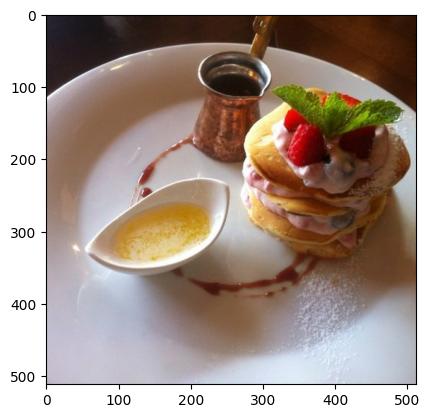

In [44]:
plt.imshow(image)

In [45]:
image = tf.cast(tf.expand_dims(image,0),tf.float32)
image/=255.0

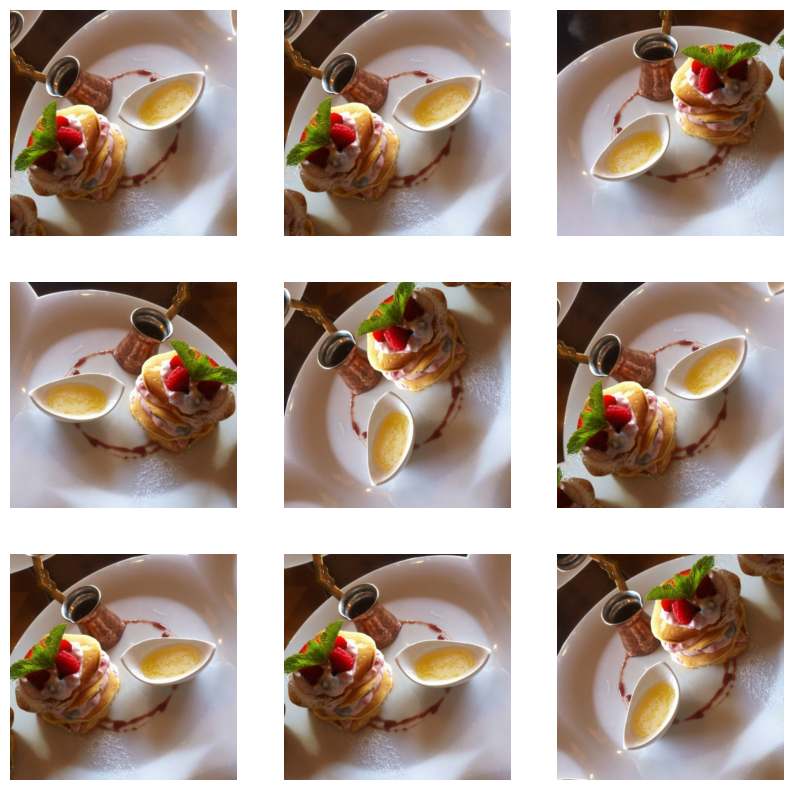

In [46]:
plt.figure(figsize=(10,10))
for i in range(9):
  agumented_image = data_agumentation(image)
  ax = plt.subplot(3,3,i+1)
  plt.imshow(agumented_image[0])
  plt.axis("off")

In [48]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
lr = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [50]:
epochs=20
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/50
    274/Unknown 381s 1s/step - accuracy: 0.4804 - loss: 1.2146

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


274/274 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.4804 - loss: 1.2136 - val_accuracy: 0.4870 - val_loss: 0.7254
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.4812 - loss: 0.7127 - val_accuracy: 0.4870 - val_loss: 0.6962
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - accuracy: 0.4812 - loss: 0.6949 - val_accuracy: 0.4870 - val_loss: 0.6934
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - accuracy: 0.4812 - loss: 0.6930 - val_accuracy: 0.4870 - val_loss: 0.6930
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.4812 - loss: 0.6928 - val_accuracy: 0.4870 - val_loss: 0.6929
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.4812 - loss: 0.6926 - val_accuracy: 0.4870 - val_loss: 0.6928
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.4812 - loss: 0.6926 - val_accuracy: 0.4870 - val_loss: 0.6928
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.4812 - loss: 0.6926 - val_accuracy: 0.487

In [51]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

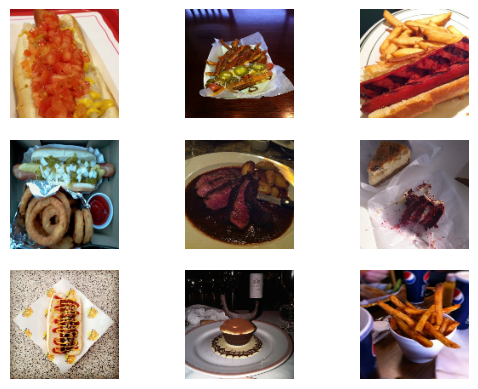

In [52]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [53]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 1, 1, 1, 0, 0, 1, 0, 0], dtype=int32)>